## Calculation

First, lets define some parameters for following

In [36]:
import pandas as pd

eval_df = pd.read_parquet("./data/66-test-dataset-with-adrd.parquet")

In [37]:
metric_names = ["google_bleu", "rouge", "meteor", "bert"]
column_names = ["gpt-4.1"]

In [ ]:
import math
import warnings

from tools.calculators import EvalCalculatorFactory
from tools.nltk_calculators import NLTKCalculator

# Construct a dictionary to store the results
res = {}
for column_name in column_names:
    res[column_name] = {
        "google_bleu": [],
        "rouge": [],
        "meteor": [],
        "bert": []
    }

# Initialize the calculator
# calculator = EvalCalculatorFactory()
calculator = NLTKCalculator(reference="", prediction="")

for idx, row in eval_df.iterrows():
    ref: str = row["Answer"]
    calculator.reference = ref
    
    for column_name in column_names:
        calculator.prediction = row[column_name]

        res[column_name]['google_bleu'].append(calculator.gleu())
        res[column_name]['rouge'].append(calculator.rouge())
        res[column_name]['meteor'].append(calculator.meteor())

        # BERT Score takes most of the time.
        bert_score = calculator.bert()
        res[column_name]['bert'].append(bert_score)

    print(f"Processed row {idx + 1}/{len(eval_df)}")

print(res)

In [39]:
for column_name in column_names:
    print(f"{column_name} - GLEU: {math.fsum(res[column_name]['google_bleu']) / len(res[column_name]['google_bleu'])}")
    print(f"{column_name} - ROUGE: {math.fsum(res[column_name]['rouge']) / len(res[column_name]['rouge'])}")
    print(f"{column_name} - METEOR: {math.fsum(res[column_name]['meteor']) / len(res[column_name]['meteor'])}")
    print(f"{column_name} - BERT: {math.fsum(res[column_name]['bert']) / len(res[column_name]['bert'])}")

gpt-4.1 - GLEU: 0.5124828929498589
gpt-4.1 - ROUGE: 0.18721818181818184
gpt-4.1 - METEOR: 0.323268766511335
gpt-4.1 - BERT: 0.6261727272727272


#### Visualization

Must hand write calculated scores in the plot data

In [40]:
# Example plot data

plot_data = {
    "adrd_dpv3": {"gleu": 0.487, "rouge": 0.216, "meteor": 0.296, "bert": 0.654},
    "adrd_qwen3_14b": {"gleu": 0.439, "rouge": 0.198, "meteor": 0.248, "bert": 0.650},
    "gpt-o3": {"gleu": 0.513, "rouge": 0.177, "meteor": 0.288, "bert": 0.620},
    "gpt-4.1": {"gleu": 0.512, "rouge": 0.187, "meteor": 0.323, "bert": 0.626}
}

Draw the plot

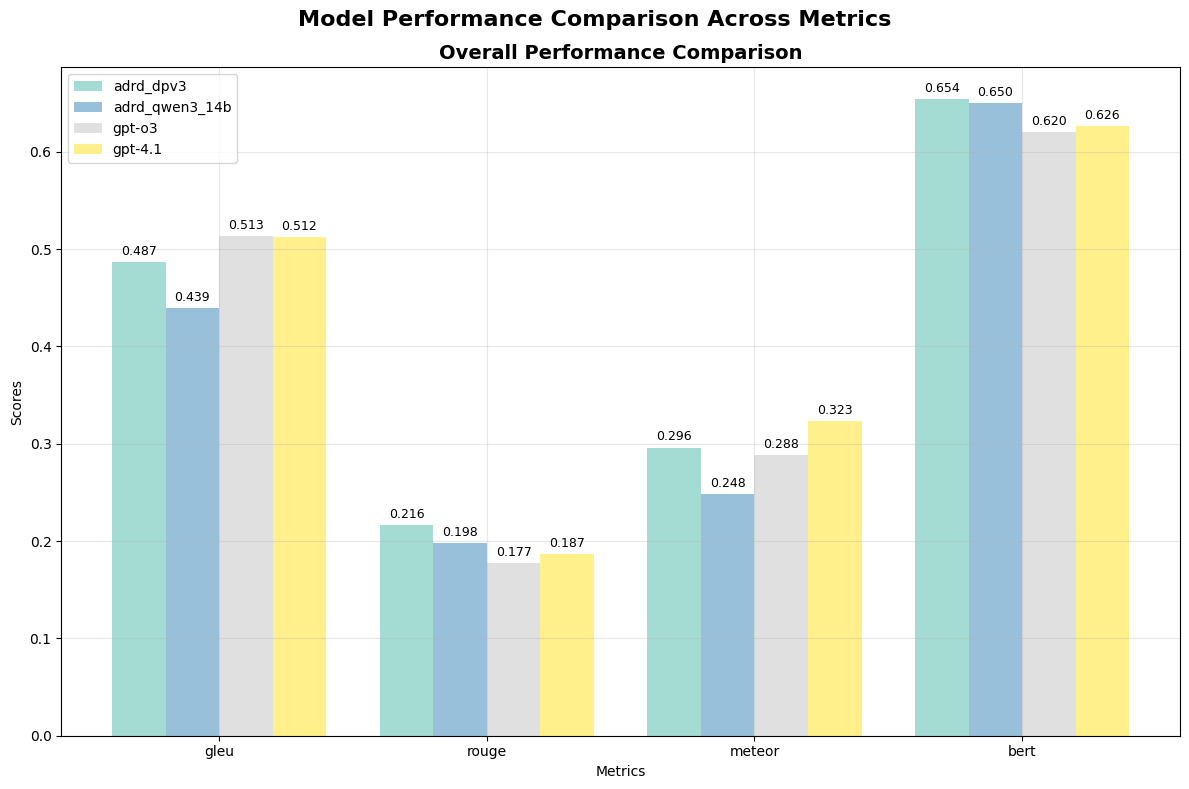

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Extract data for plotting
models = list(plot_data.keys())
metrics = list(plot_data[models[0]].keys())

# Create figure with subplots
fig, ax = plt.subplots(figsize=(12, 8))
fig.suptitle("Model Performance Comparison Across Metrics", fontsize=16, fontweight="bold")

# Color scheme - generate colors for all models
colors = plt.cm.Set3(np.linspace(0, 1, len(models)))

# Bar chart comparing all metrics
ax.set_title("Overall Performance Comparison", fontsize=14, fontweight="bold")
x = np.arange(len(metrics))
width = 0.8 / len(models)  # Adjust width based on number of models

# Plot bars for each model
bars = []
for i, model in enumerate(models):
    model_scores = [plot_data[model][metric] for metric in metrics]
    bar = ax.bar(x + i * width - (len(models) - 1) * width / 2, 
                model_scores, width, label=model, color=colors[i], alpha=0.8)
    bars.append(bar)

ax.set_xlabel("Metrics")
ax.set_ylabel("Scores")
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.grid(True, alpha=0.3)

# Add value labels on bars
for bar_group in bars:
    for bar in bar_group:
        height = bar.get_height()
        ax.annotate(f"{height:.3f}",
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

## Calculation without reference

In [ ]:
example_text = """
When looking for activities for someone with dementia, it is important to consider their interests and hobbies [1]. Taking inventory of their past and current interests can help you come up with ideas. Some examples of activities that they might enjoy include gardening, crafting, playing or watching sports, cooking, reading about historical events, fishing, photography, or listening to or playing certain types of music [1].

It is also important to adapt these activities to fit their abilities as their condition progresses [1]. Providing additional assistance and supervision may be necessary, but adapting the activities themselves is also important. For example, if they enjoyed reading, you can take turns reading a favorite book aloud to them [2]. This can help exercise their mind and give them the pleasure of reading a beloved book.

Listening to music is another activity that can be enjoyable for someone with dementia [2]. Research has shown that music can help them remember events, people, and places from their past. It can also be a way to get them moving through dance or song. You can choose music that matches their needs, such as sing-along activities, upbeat motivating tunes, or relaxing sounds [2].

In addition, there are activity boards available for purchase that are specifically designed for people with dementia [3]. These boards have various tasks on them, such as buttons, zippers, and Velcro, and include things with different textures and sounds. They are aimed at keeping a person's hands busy and providing mental stimulation [3].

Overall, when selecting activities for someone with dementia, it is important to consider their interests, adapt the activities to their abilities, and provide the necessary support and supervision. Activities such as gardening, crafting, reading, listening to music, and using activity boards can be enjoyable and engaging for individuals with dementia.

References:
[1] https://www.agingcare.com/articles/my-elderly-parent-has-dementia-what-activities-can-we-do-together-137087.htm
[2] https://www.agingcare.com/articles/activities-for-alzheimers-148840.htm
[3] https://www.agingcare.com/articles/hobbies-and-activities-for-seniors-tips-from-family-caregivers-205881.htm
"""


def truncate_text(text: str) -> str:
    return text.split("References:")[0]


print(truncate_text(example_text))

In [ ]:
# Redo calculation use answers without references.

import math
import warnings
from time import sleep

from tools.calculators import EvalCalculatorFactory

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

score_list = {
    "bleu": [],
    "rouge": [],
    "char_f": [],
    "bert": [],
}

for idx, row in eval_df.iterrows():
    ref = truncate_text(row["Answer"])
    pred = truncate_text(row["adrd_dpv3"])
    
    calculator = EvalCalculatorFactory(predictions=[pred], references=[ref])
    score_list["bleu"].append(calculator.bleu()["bleu"])
    score_list["bert"].append(calculator.bert()["f1"][0])
    score_list["rouge"].append(calculator.rouge()["rougeLsum"])
    score_list["char_f"].append(calculator.char_f()["score"])
    
    sleep(1)

# print(score_list)

print(f"BLEU: {math.fsum(score_list['bleu']) / len(score_list['bleu'])}")
print(f"BERT: {math.fsum(score_list['bert']) / len(score_list['bert'])}")
print(f"ROUGE: {math.fsum(score_list['rouge']) / len(score_list['rouge'])}")
print(f"CHAR_F: {math.fsum(score_list['char_f']) / len(score_list['char_f'])}")
